# Plot Source Time in Selected Objects

 work with Weakly_2023_44
- use jupyter kernel LSST
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/12/30
- update : 2023/12/30


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle

plt.rcParams["figure.figsize"] = (16,10)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
# A repo which exists at the USDF, contains data from various instruments and
REPO = '/repo/embargo'

from lsst.daf.butler import Butler
from pprint import pprint

# Here we specify a default collection to use
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"
butler = Butler(REPO, collections=my_collection)
registry = butler.registry

In [3]:
#import lsst.sphgeom
from  lsst.geom import SpherePoint, Angle
import lsst.sphgeom

import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom
afwDisplay.setDefaultBackend('matplotlib')
plt.rcParams['figure.figsize'] = (8.0, 8.0)

In [4]:
Angle(3.1415).asDegrees()

179.9946913403481

In [5]:
Angle(3.1415).asRadians()

3.1415

In [6]:
SpherePoint(Angle(3.1415),Angle(1.0))

SpherePoint(179.9946913403481*degrees, 57.29577951308232*degrees)

In [7]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import coordinates

In [8]:
import pandas as pd

In [9]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

## Config

### Galactic Plane

In [10]:
gal_long = np.linspace(-180.,180,360)
gal_lat = np.zeros((360))

coordinates_galactic_planes = SkyCoord(l=gal_long*u.degree, b=gal_lat*u.degree, frame='galactic')
gp_radec = coordinates_galactic_planes.transform_to('icrs')  

gp_ra_toplot = coordinates.Angle(gp_radec.ra.degree*u.degree)
gp_ra_toplot = gp_ra_toplot.wrap_at(180*u.degree)

### Sources

In [11]:
file = "sourceTable_202312.csv"
file_visit = "sourceTablevisit_202312.csv"

In [12]:
suptitle = "Sources, Auxtel phot 2023"

## Skymap, Tracts and Patchs

In [13]:
Auxtel2023_tracts = [ 5616,5634,5615,10644,383,8188,3863,455,452,5839,10643,382]

In [14]:
skymap_auxtel ='latiss_v1'

In [15]:
skymap = butler.get('skyMap', skymap=skymap_auxtel, collections=my_collection)

In [16]:
with open('Latiss_tractspatchs.pickle', 'rb') as handle:
    tracts_patchs_dict = pickle.load(handle)

In [17]:
tracts_patchs_dict

{5616: array([335, 355, 358, 336, 337, 338, 316, 357, 317, 356]),
 5634: array([ 91,  52,  93,  72,  92, 109, 110,  54,  71,  53,  55, 112, 111,
         74,  73,  90]),
 5615: array([332, 333, 312, 313, 295, 331, 276, 275, 294, 293, 314, 274]),
 10644: array([166, 184, 183, 201, 161, 180, 207, 188, 202, 182, 189, 208, 164,
        181, 185, 165, 203, 162]),
 383: array([359, 360]),
 8188: array([48, 65, 47, 28, 46, 66, 27]),
 3863: array([241, 243, 242, 260, 261, 222, 262, 224, 223]),
 455: array([52, 33, 51, 32, 14, 53, 34, 15, 13]),
 452: array([42, 44, 25, 24, 63, 23, 43, 62]),
 5839: array([9, 7, 8]),
 10643: array([171, 190]),
 382: array([343, 342])}

### Should try Tracts
- 5615 - OK , Not in our galaxy
- 5616 - Non, 1 nuit
- 5839 - Non, 1 nuit
- 5634 - OK - Galaxie Plane

In [18]:
tract_selected = 5615

In [19]:
tractInfo = skymap.generateTract(tract_selected)

In [20]:
tractInfo.contains 

<bound method TractInfo.contains of TractInfo(id=5615, ctrCoord=[-0.4548159976772596, -0.7877644160721412, -0.4154150130018864])>

In [21]:
def SourceInTract(row):
    #coord_dec
    #coord_ra
    #print(row)
    try:
        ra = row["ra"]
        dec = row["dec"]
        ra_rad = ra*np.pi/180.
        dec_rad = dec*np.pi/180.
        spherepoint = SpherePoint(Angle(ra_rad),Angle(dec_rad))
        flag = tractInfo.contains( spherepoint)
        return flag
    except Exception as err:
        print(f"Unexpected {err=}, {type(err)=}")
        return False
        
    

### Selected Objects

In [22]:
fileobjects_in = "objectTableselected_202312.csv"

In [23]:
df_selobj = pd.read_csv(fileobjects_in)

In [24]:
index_selected_object = 10
the_obj=df_selobj.iloc[index_selected_object]

In [25]:
the_obj

Unnamed: 0                         25142
objectId             2229049818594936782
tabid_idx                             44
x                           28044.380418
y                           46336.611186
coord_ra                      240.013828
coord_dec                     -24.049977
tract                               5615
patch                                294
refExtendedness                      0.0
detect_isPrimary                    True
detect_isIsolated                  False
g_calibFlux                866634.517995
g_psfFlux                 1192480.210415
g_cModelFlux              1189302.104069
g_kronFlux                1193715.153839
r_calibFlux               1524653.626644
r_psfFlux                 2048635.842828
r_cModelFlux              2046116.156301
r_kronFlux                2023092.733422
i_calibFlux               1928972.674568
i_psfFlux                 2508878.731082
i_cModelFlux              2494196.561716
i_kronFlux                2479524.410025
g_psfMag        

In [26]:
suptitle += f" {index_selected_object}) Object {the_obj.objectId }"

In [27]:
the_obj.objectId 

2229049818594936782

In [28]:
vect_to_object = lsst.sphgeom.UnitVector3d(lsst.sphgeom.LonLat.fromDegrees(the_obj.coord_ra, the_obj.coord_dec))

In [29]:
spherePointCenter = lsst.geom.SpherePoint(the_obj.coord_ra*lsst.geom.degrees, the_obj.coord_dec*lsst.geom.degrees)

## Input

In [30]:
df = pd.read_csv(file,index_col=0)
#df_visit = pd.read_csv(file_visit,index_col=0)

In [31]:
list_of_columns = sorted(list(df.columns))

In [32]:
#for col in list_of_columns:
#    print(col)

## Selection

In [33]:
df.dropna(inplace=True)
selection1 = df["extendedness_flag"] == False
selection2 = df["detect_isPrimary"] == True
df = df[selection1 & selection2 ]

### Selection for one object

In [34]:
#df["inptract"]=df[["ra","dec"]].apply(SourceInTract)

In [35]:
cut_arcsc = 12.0

In [36]:
all_angles = []
for index, row in df.iterrows():
    spt = lsst.geom.SpherePoint(row["coord_ra"]*lsst.geom.degrees, row["coord_dec"]*lsst.geom.degrees)
    ang = spherePointCenter.separation(spt)
    ang_arcsec = ang.asArcseconds()
    all_angles.append(ang_arcsec)

In [37]:
df["sep"] = all_angles

In [38]:
df["sep"].min() 

0.005859087657321788

In [39]:
df.sort_values(by=["dateobs"],inplace=True)

Text(0.5, 0.98, 'Sources, Auxtel phot 2023 10) Object 2229049818594936782')

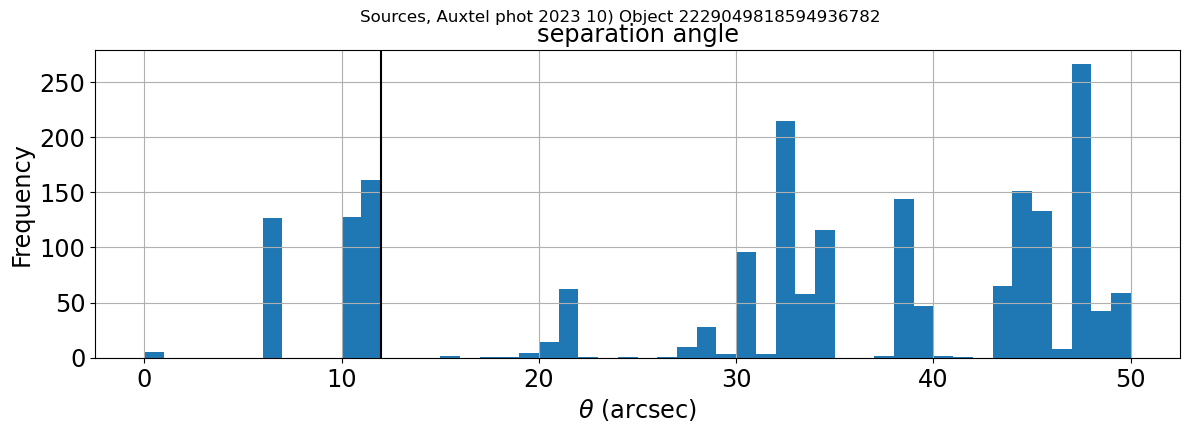

In [40]:
fig, ax = plt.subplots(1,1,figsize=(14,4))
df['sep'].plot(kind="hist",bins=50,range=(0,50),ax=ax,grid=True,title="separation angle")
ax.axvline(cut_arcsc,color="k")
ax.set_xlabel("$\\theta$ (arcsec)")
plt.suptitle(suptitle)

In [41]:
selection3 = df['sep']< cut_arcsc
df = df[selection3 ]

## Magnitudes

In [42]:
df["psfMag"] = df["psfFlux"].map(convert_fluxtomag)
df["gaussianMag"] = df["gaussianFlux"].map(convert_fluxtomag)
df["calibMag"] = df["calibFlux"].map(convert_fluxtomag)

/tmp/ipykernel_41986/4088867659.py:12: RuntimeWarning: invalid value encountered in log10
  return -2.50 * np.log10(x) + 31.4


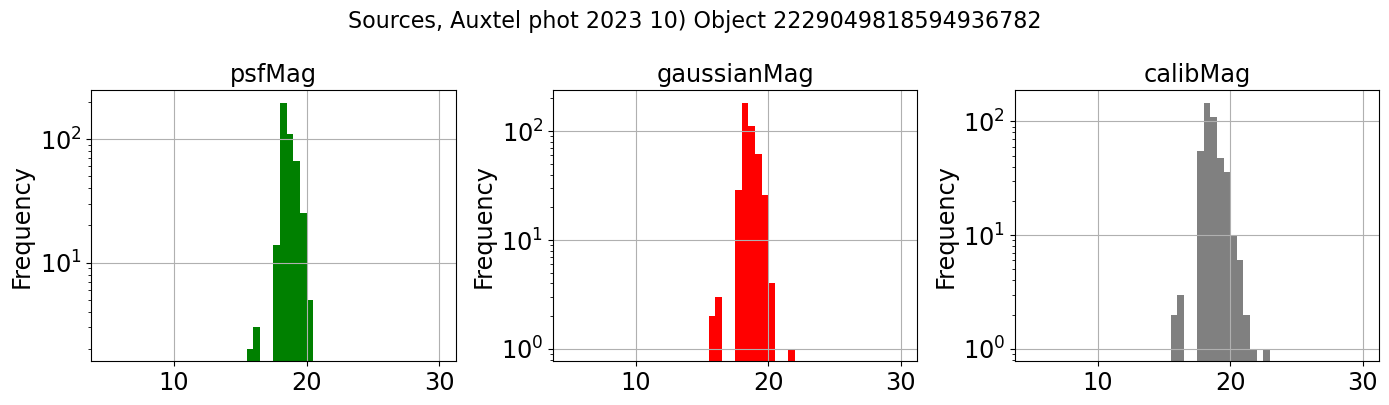

In [43]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))

df['psfMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="g",logy=True,grid=True,title="psfMag",ax=ax1)
df['gaussianMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="r",logy=True,grid=True,title="gaussianMag",ax=ax2)
df['calibMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="grey",logy=True,grid=True,title="calibMag",ax=ax3)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()


## Convert dateobs into datetime

In [44]:
df[["dateobs","sep","band","ccdVisitId",'x','y']]

,dateobs,sep,band,ccdVisitId,x,y
sourceId,,,,,,
171629648369680420,2023-05-12 01:08:41.181,11.384909,r,40919696896,3824.798670,689.025743
171629648369680413,2023-05-12 01:08:41.181,10.704002,r,40919696896,3875.033379,610.316584
171629656959615139,2023-05-12 01:22:21.029,10.738795,i,40919698944,303.011991,2579.920667
171629658033356897,2023-05-12 01:24:31.937,11.362850,i,40919699200,2957.036732,1286.639283
171629660180840565,2023-05-12 01:27:32.143,11.353622,r,40919699712,1065.081288,2533.905732
...,...,...,...,...,...,...
177012886290300939,2023-10-12 00:11:45.432,11.515504,g,42203160832,2167.268726,350.917463
177012886290301166,2023-10-12 00:11:45.432,6.305581,g,42203160832,2200.081171,465.974578
177012887364042762,2023-10-12 00:12:35.427,10.445638,g,42203161088,1699.071493,328.879943


In [45]:
df["Time"] = pd.to_datetime(df['dateobs'])

Text(0.5, 0.98, 'Sources, Auxtel phot 2023 10) Object 2229049818594936782')

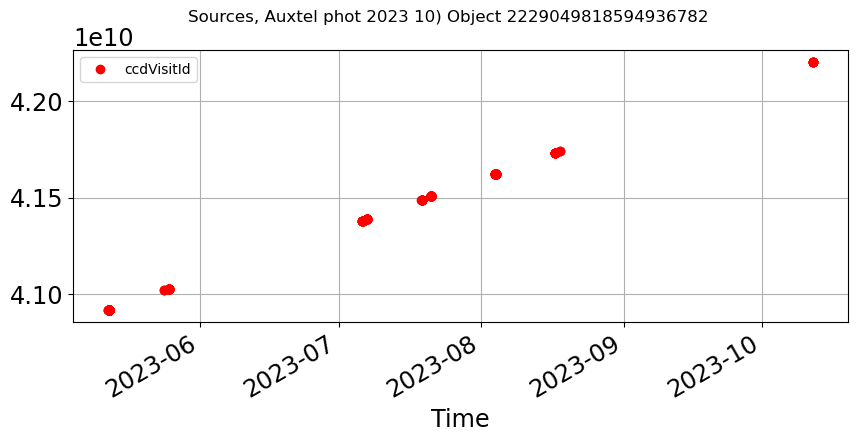

In [46]:
fig,ax = plt.subplots(1,1,figsize=(10,4))
df.plot(x="Time",y="ccdVisitId",marker='o',c="r",lw=0.0,ax=ax,grid=True)
plt.suptitle(suptitle)

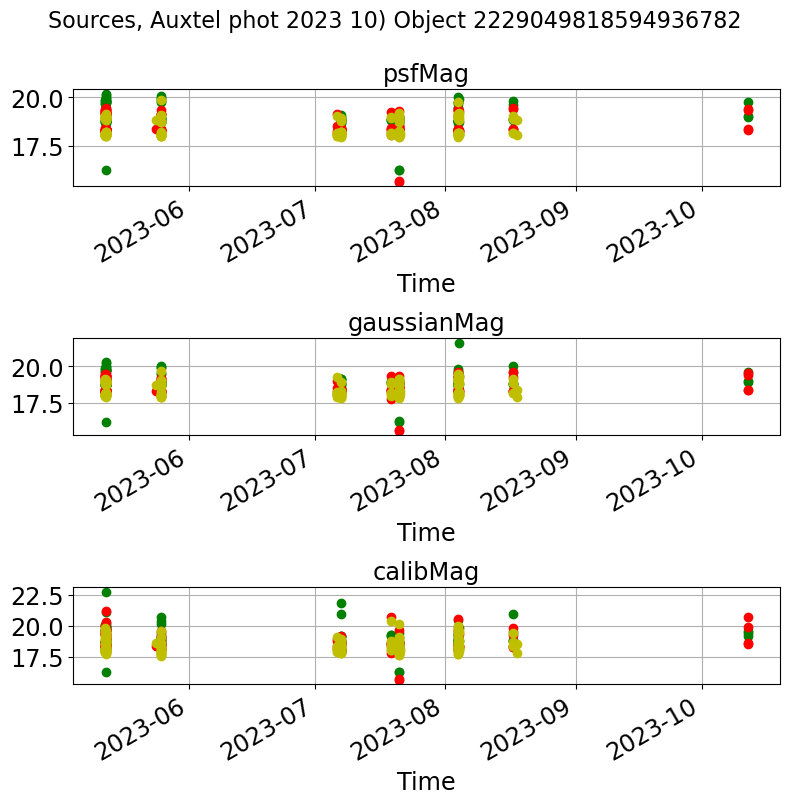

In [47]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1)

df[df["band"]=="g"].plot(x="Time",y="psfMag",marker='o',c="g",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="psfMag",marker='o',c="r",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="psfMag",marker='o',c="y",lw=0.0,ax=ax1,grid=True,legend=False)
ax1.set_title("psfMag")

df[df["band"]=="g"].plot(x="Time",y="gaussianMag",marker='o',c="g",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="gaussianMag",marker='o',c="r",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="gaussianMag",marker='o',c="y",lw=0.0,ax=ax2,grid=True,legend=False)
ax2.set_title("gaussianMag")

df[df["band"]=="g"].plot(x="Time",y="calibMag",marker='o',c="g",lw=0.0,ax=ax3,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="calibMag",marker='o',c="r",lw=0.0,ax=ax3,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="calibMag",marker='o',c="y",lw=0.0,ax=ax3,grid=True,legend=False)
ax3.set_title("calibMag")

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

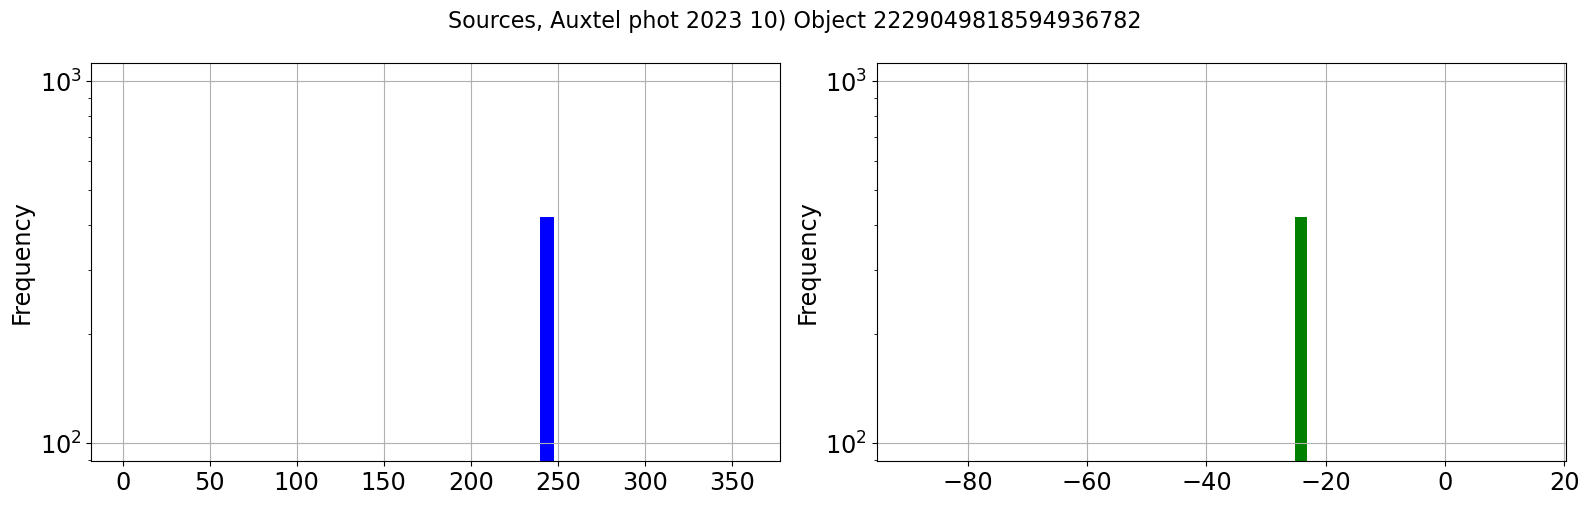

In [48]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
df_sel = df["coord_ra"]
df_sel.plot(kind="hist",x="coord_ra",bins=45,range=(0,360),facecolor="b",ax=ax1,grid=True,logy=True)
df_sel = df["coord_dec"]
df_sel.plot(kind="hist",x="coord_dec",bins=55,range=(-90,15),facecolor="g",ax=ax2,grid=True,logy=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

In [49]:
list_of_ccdvisits = df[["ccdVisitId"]].values.flatten()
list_of_ccdvisits

array([40919696896, 40919696896, 40919698944, 40919699200, 40919699712,
       40919699712, 40919699968, 40919699968, 40919700480, 40919700736,
       40919700736, 40919700992, 40919701248, 40919701248, 40919701504,
       40919701504, 40919701504, 40919701760, 40919702016, 40919702016,
       40919702016, 40919702272, 40919702272, 40919702272, 40919702784,
       40919703040, 40919703040, 40919703296, 40919703296, 40919703552,
       40919703552, 40919703808, 40919703808, 40919704064, 40919704576,
       40919704576, 40919704832, 40919705088, 40919705088, 40919705344,
       40919705344, 40919705344, 40919705856, 40919706112, 40919706112,
       40919706624, 40919706624, 40919706880, 40919706880, 40919707136,
       40919707136, 40919707392, 40919707648, 40919707648, 40919707904,
       40919708160, 40919708160, 40919708416, 40919708416, 40919708416,
       40919708672, 40919708672, 40919708928, 40919709184, 40919709184,
       40919709440, 40919709440, 40919709696, 40919709696, 40919

In [50]:
dataId = {'instrument': 'LATISS', 'detector': 0}
df_visit = butler.get('ccdVisitTable', dataId=dataId)

In [51]:
df_visit.columns

Index(['visitId', 'physical_filter', 'band', 'ra', 'dec', 'zenithDistance',
       'zeroPoint', 'psfSigma', 'skyBg', 'skyNoise', 'astromOffsetMean',
       'astromOffsetStd', 'nPsfStar', 'psfStarDeltaE1Median',
       'psfStarDeltaE2Median', 'psfStarDeltaE1Scatter',
       'psfStarDeltaE2Scatter', 'psfStarDeltaSizeMedian',
       'psfStarDeltaSizeScatter', 'psfStarScaledDeltaSizeScatter',
       'psfTraceRadiusDelta', 'maxDistToNearestPsf', 'decl', 'detector',
       'seeing', 'skyRotation', 'expMidpt', 'expMidptMJD', 'expTime',
       'obsStart', 'obsStartMJD', 'darkTime', 'xSize', 'ySize', 'llcra',
       'llcdec', 'ulcra', 'ulcdec', 'urcra', 'urcdec', 'lrcra', 'lrcdec'],
      dtype='object')

In [52]:
df_visit.loc[list_of_ccdvisits[0]]

visitId                                       2023051100262
physical_filter                            SDSSr_65mm~empty
band                                                      r
ra                                               239.946727
dec                                              -24.053746
zenithDistance                                    56.749516
zeroPoint                                         27.705477
psfSigma                                           7.776608
skyBg                                             11.197219
skyNoise                                           7.856582
astromOffsetMean                                   0.032861
astromOffsetStd                                    0.019685
nPsfStar                                                 39
psfStarDeltaE1Median                              -0.004245
psfStarDeltaE2Median                              -0.001485
psfStarDeltaE1Scatter                              0.031742
psfStarDeltaE2Scatter                   

In [53]:
#print(list(df_visit.index))

In [54]:
#results = set(butler.registry.queryDataIds('visit', dataId={"tract":tract_selected, "skymap":"latiss_v1"}))
#pprint(results)

In [55]:
datasettype = 'calexp.visitInfo'
all_calexp = []
all_dataId = []
for idx,ccdvisit in enumerate(list_of_ccdvisits):
    try:
        visitid = df_visit.loc[ccdvisit]["visitId"]
        dayobs = visitid //100_000
        dataId = {'visit': visitid, 'detector': 0}
        visitInfo = butler.get(datasettype, dataId=dataId )
        calexp = butler.get('calexp', dataId=dataId)
        if idx<2:
            all_calexp.append(calexp)
            all_dataId.append(dataId)
        #print(visitInfo)
        print(visitid,dayobs,":","az=",visitInfo.boresightAzAlt[0],"alt=",visitInfo.boresightAzAlt[1],"am=",visitInfo.boresightAirmass)
    except Exception as err:
        print(f"Unexpected {err=}, {type(err)=}")
        

2023051100262 20230511 : az= 1.75672 rad alt= 0.577341 rad am= 1.82658799205201
2023051100262 20230511 : az= 1.75672 rad alt= 0.577341 rad am= 1.82658799205201
2023051100270 20230511 : az= 1.73286 rad alt= 0.627834 rad am= 1.69767983078411
2023051100271 20230511 : az= 1.72906 rad alt= 0.635834 rad am= 1.67977925489903
2023051100273 20230511 : az= 1.72378 rad alt= 0.646864 rad am= 1.65489159927369
2023051100273 20230511 : az= 1.72378 rad alt= 0.646864 rad am= 1.65489159927369
2023051100274 20230511 : az= 1.71997 rad alt= 0.65498 rad am= 1.63786428709841
2023051100274 20230511 : az= 1.71997 rad alt= 0.65498 rad am= 1.63786428709841
2023051100276 20230511 : az= 1.71467 rad alt= 0.665845 rad am= 1.61489172000838
2023051100277 20230511 : az= 1.71094 rad alt= 0.673773 rad am= 1.5992868755092
2023051100277 20230511 : az= 1.71094 rad alt= 0.673773 rad am= 1.5992868755092
2023051100278 20230511 : az= 1.70696 rad alt= 0.682094 rad am= 1.58248521168471
2023051100279 20230511 : az= 1.70264 rad alt

(-0.5, 4071.5, -0.5, 3999.5)

<Figure size 800x800 with 0 Axes>

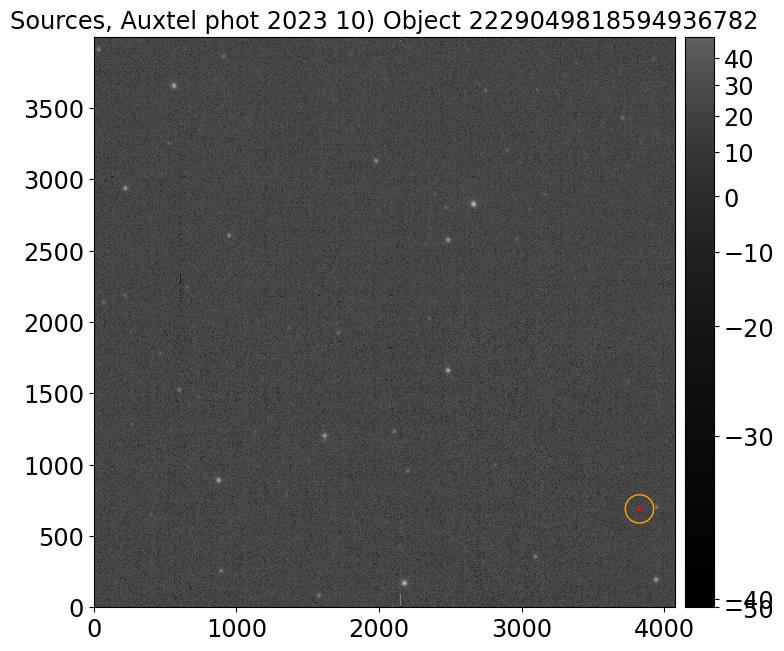

In [56]:
# Plot the calexp we just retrieved
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(all_calexp[0].image,title=suptitle)

with afw_display.Buffering():
    x = df.iloc[0]['x']
    y = df.iloc[0]['y']
    afw_display.dot('o', x , y, size=100, ctype='orange')
    afw_display.dot('+', x , y, size=10, ctype='red')

plt.gca().axis('on')
